In [1]:
from io import BytesIO
import tempfile
import zipfile
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from pathlib import Path
import concurrent.futures
from glob import glob
import geopandas as gpd
from shapely import wkt, Point
import pyproj
from IPython.display import clear_output
import unicodedata
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


In [2]:
!pip install basedosdados==2.0.0b16
clear_output()

# Constantes Globais

In [3]:
billing_project_id = "br-fbsp-absp" # Define o nome do projeto Google que está vinculado ao email do colab

# Funçoes Globais

In [4]:

def slugify(s: str) -> str:
  s = s.strip().lower()
  s = unicodedata.normalize("NFD", s)
  s = s.encode("ascii", "ignore")
  s = s.decode("utf-8")
  s = s.lower().strip()
  return s

# [Censo][censo-2022]

- [x] População total
- [x] ~~Mulheres chefes de família e com filhos menores de 15 anos(Não encontrado no Censo)~~
- [x] % de pessoas de 65 anos ou mais -> [Codigo][indicadores_8]
- [x] Total de pessoas de 65 anos ou mais -> [Codigo][indicadores_8]
- [x] ~~% de mães chefes de família, sem fundamental completo e com filho menor de 15 anos de idade(Não encontrado no Censo)~~
- [x] % Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever -> [Codigo][indicadores_1]
- [x] Cor
- [x] Proporção de crianças de 0 a 4 anos na população
- [x] ~~Proporção de mulheres responsáveis pelo domicílio com menos de 30 anos (Não encontrado no Censo)~~
- [x] Proporção de mulheres responsáveis pelo domicílio - Incidência distrital de chefe de família mulher (Sera mesma coisa?)
- [X] Incidência distrital de longevidade (pessoas acima de 70 anos).(Parecida com "% de pessoas de 65 anos ou mais") -> [Codigo][indicadores_8]
- [x] Proporção de pessoas responsáveis de 12 a 24 anos(Proporção de pessoas responsáveis de 10 a 29 anos) ->  [Codigo][indicadores_3]
- [x] Proporção de mulheres reponsáveis com menos de 15 a 29 anos -> [Codigo][indicadores_4]
- [x] Proporção de pessoas responsáveis não alfabetizadas
- [x] % da população que vive em domicílios urbanos com o serviço de coleta de lixo -> [Codigo][indicadores_14]


# Notas

Indicadores com 'Incidência' talvez tenha faltado a informação de (cada x elementos)


[censo-2022]: https://www.ibge.gov.br/estatisticas/sociais/trabalho/22827-censo-demografico-2022.html?=&t=downloads

<!-- Mães chefes de família sem fundamental completo e com filho menor de 15 no distrito -->
[indicadores_1]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=asIcppjP882W

<!-- Proporção de pessoas responsáveis de 10 a 29 anos -->
[indicadores_3]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=iLHtxICXF1wj

<!-- Proporção de mulheres responsáveis pelo domicílio com menos de 30 anos -->
[indicadores_4]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=lTz1c2SoQocK

<!-- % de pessoas de 65 anos ou mais -->
[indicadores_8]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=8ekPcHrWzgxd

[indicadores_14]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=j9tKAV8qvaEW

## Funçoes

In [5]:
def download_files_from_ftp(url: str) -> None:
    """
    Baixa um arquivo do FTP e retorna seu conteúdo em memória.

    Parâmetros:
    url (str): URL do arquivo a ser baixado.

    Retorna:
    Arquivo será baixado e extraido na pasta "data/input"
    """
    base_path = Path("data")
    path_input = base_path / "input"

    response = requests.get(url, stream=True)
    response.raise_for_status()

    save_path = path_input / url.split('/')[-1]

    path_input.mkdir(parents=True, exist_ok=True)

    with open(save_path, "wb") as fd:
        for chunk in response.iter_content(chunk_size=128):
            fd.write(chunk)

    with zipfile.ZipFile(save_path) as z:
        z.extractall(path_input)

def get_sp_distrito_from_csv(path_csv: str) -> pd.DataFrame:

  name_file = path_csv.split('/')[-1]

  temp_df = pd.read_csv(path_csv, encoding='iso-8859-1', sep=";", dtype=str)

  df_sp_distritos = temp_df[temp_df.CD_DIST.str.contains("3550308")]

  return df_sp_distritos

def get_sp_setor_from_csv(path_csv: str, ids_seto: list) -> pd.DataFrame:

  name_file = path_csv.split('/')[-1]

  temp_df = pd.read_csv(path_csv, encoding='iso-8859-1', sep=";", dtype=str)

  temp_df.columns = temp_df.columns.str.upper()

  df_sp_distritos = temp_df[temp_df.CD_SETOR.isin(ids_seto)]

  return df_sp_distritos

def excel_sheet_to_df( path_dicionario: str, sheet_name: str) -> pd.DataFrame:

  temp_df_sheet = pd.read_excel(path_dicionario, sheet_name=sheet_name)

  temp_df_sheet = temp_df_sheet[['Variável', 'Descrição']]

  return temp_df_sheet

## Download

In [6]:
url_agregados_por_distrito_csv = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/Agregados_por_Distrito_csv/'
url_sp_distrito_geo = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP/SP_distritos_CD2022.zip'
url_dicionario_de_dados = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/dicionario_de_dados_agregados_por_setores_censitarios.xlsx'

response = requests.get(url_agregados_por_distrito_csv)

soup = BeautifulSoup(response.text)

links_agregados_por_distrito_csv = [url_agregados_por_distrito_csv + a.get('href') for a in soup.select('td a') if a.get('href').count('zip')] # Coleta o link dos Arquivos

links_agregados_por_distrito_csv.extend([url_sp_distrito_geo, url_dicionario_de_dados]) # Adicionando tabela Distrito Geografico e Dicionario a lista de download

with concurrent.futures.ThreadPoolExecutor() as executor:
  executor.map(download_files_from_ftp, links_agregados_por_distrito_csv)



## Preparar DataFrame - [Censo 2022][censo-2022]

[censo-2022]: https://www.ibge.gov.br/estatisticas/sociais/trabalho/22827-censo-demografico-2022.html?=&t=downloads

In [7]:
# Define tabela com as GeoGrafias
geo_df_sp = gpd.read_file('/content/data/input/SP_distritos_CD2022.shp', columns=['CD_DIST', 'NM_DIST', 'geometry'])
geo_df_sp = geo_df_sp[geo_df_sp.CD_DIST.str.contains("3550308")]

# Carrega o Dicionario e Prepara ele para o Rename
path_dicionario = '/content/data/input/dicionario_de_dados_agregados_por_setores_censitarios.xlsx'
sheet_names = ['Dicionário Básico', 'Dicionário não PCT', 'Dicionário PCT - Indígenas', 'Dicionário PCT - Quilombolas']

df_dicionario = pd.concat([excel_sheet_to_df(path_dicionario, sheet_name) for sheet_name in sheet_names])

dicionario_to_rename = dict(zip(df_dicionario.Variável, df_dicionario.Descrição))

# Carrega e trata tabela final

regex_glob = '/content/data/input/*.csv'

csv_files = glob(regex_glob)

temp_dfs = [get_sp_distrito_from_csv(csv_path) for csv_path in csv_files]

temp_dfs.append(geo_df_sp) # Adicionando tabela Distrito Geografico

first_temp_df = temp_dfs.pop(0) # Seleciona primeira tabela e remove ela da lista

for temp_df in temp_dfs:

  temp_df.drop('NM_DIST', axis=1, inplace=True)

  first_temp_df = pd.merge(
      first_temp_df,
      temp_df,
      how="left",
      on="CD_DIST"
  )

first_temp_df.columns = first_temp_df.columns.str.upper() # Coloca todas as colunas como Upper para manipulação de nomes

# Tratar ordem e nome das colunas
columns_to_sorted = first_temp_df.columns[first_temp_df.columns.str.startswith('V')].sort_values().tolist()
first_columns = first_temp_df.columns[~first_temp_df.columns.str.startswith('V')].tolist()
column_order = first_columns + columns_to_sorted

first_temp_df = first_temp_df[column_order]

## Indicadores - [Censo 2022][censo-2022]

[censo-2022]: https://www.ibge.gov.br/estatisticas/sociais/trabalho/22827-censo-demografico-2022.html?=&t=downloads

### População total - Censo 2022

In [8]:
# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
populacao_censo_2022 = first_temp_df[['NM_DIST', 'V0001']]
populacao_censo_2022.index = populacao_censo_2022.NM_DIST
populacao_censo_2022 = populacao_censo_2022['V0001']

### % de pessoas de 65 anos ou mais - Censo 2022
Formula:

$\text{%} = \frac{\text{Total de Pessoas De 65 Mais}}{\text{Total De Pessoas}} \times 100$

Indicadores resultante desse codigo:
- total de pessoas de 65 anos ou mais - Censo 2022
- % de pessoas de 65 anos ou mais - Censo 2022





In [9]:
# V0001: Total de pessoas
# V00654: 65 a 69 anos
# V00655: 70 a 79 anos
# V00656: 80 anos ou mais

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = ['V0001', 'V00654','V00655','V00656']
columns_indicadores: list[str] = ['total de pessoas de 65 anos ou mais', '% de pessoas de 65 anos ou mais']

# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
pessoas_65_censo_2022 = first_temp_df[['NM_DIST', 'V0001', 'V00654','V00655','V00656']].copy()

pessoas_65_censo_2022[columns_str_to_int] = pessoas_65_censo_2022[columns_str_to_int].astype(int)

# % = (total de pessoas de 65 anos ou mais ÷ Total de pessoas) x 100
pessoas_65_censo_2022['total de pessoas de 65 anos ou mais'] = pessoas_65_censo_2022[['V00654','V00655','V00656']].sum(axis=1)
pessoas_65_censo_2022['% de pessoas de 65 anos ou mais'] = (pessoas_65_censo_2022['total de pessoas de 65 anos ou mais'] / pessoas_65_censo_2022['V0001']).round(3)
pessoas_65_censo_2022['% de pessoas de 65 anos ou mais'] = pessoas_65_censo_2022['% de pessoas de 65 anos ou mais'] * 100

pessoas_65_censo_2022.index = pessoas_65_censo_2022.NM_DIST
pessoas_65_censo_2022 = pessoas_65_censo_2022[columns_indicadores]

### Cor

Apenas foi feita uma seleção de colunas

In [10]:
# V01317: Cor ou raça é branca
# V01318: Cor ou raça é preta
# V01319: Cor ou raça é amarela
# V01320: Cor ou raça é parda
# V01321 : Cor ou raça é indígena

df_cor = first_temp_df[['NM_DIST', 'V01317', 'V01318','V01319','V01320', 'V01321']].copy()

df_cor.index = df_cor.NM_DIST
df_cor = df_cor.iloc[:, 1:]

### Proporção de crianças de 0 a 4 anos na população

Seguinte fórmula:

$\text{Proporção} = \frac{\text{Número de crianças de 0 a 5 anos}}{\text{População total}} \times 100$


In [11]:
# V0001: Total de pessoas
# V01031: 0 a 4 anos

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = ['V0001', 'V01031']

# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
crianca_zero_to_five = first_temp_df[['NM_DIST', 'V0001', 'V01031']].copy()

crianca_zero_to_five[columns_str_to_int] = crianca_zero_to_five[columns_str_to_int].astype(int)

# % = (total de pessoas de 65 anos ou mais ÷ Total de pessoas) x 100
crianca_zero_to_five['Proporção de crianças de 0 a 4 anos na população'] = (crianca_zero_to_five['V01031'] / crianca_zero_to_five['V0001']).round(3)
crianca_zero_to_five['Proporção de crianças de 0 a 4 anos na população'] = crianca_zero_to_five['Proporção de crianças de 0 a 4 anos na população'] * 100

crianca_zero_to_five.index = crianca_zero_to_five.NM_DIST
crianca_zero_to_five = crianca_zero_to_five.iloc[:, 1:]

### Proporção de mulheres responsáveis pelo domicílio

Seguinte fórmula:

$\text{Proporção de mulheres responsáveis pelo domicílio} = \frac{\text{Pessoa responsável pelo domicílio, Sexo feminino}}{\text{Pessoa responsável pelo domicílio}} \times 100$


In [12]:
# V01042: Pessoa responsável pelo domicílio
# V01063: Pessoa responsável pelo domicílio, Sexo feminino

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = ['V01042', 'V01063']

# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
mulheres_responsaveis = first_temp_df[['NM_DIST', 'V01042', 'V01063']].copy()

mulheres_responsaveis[columns_str_to_int] = mulheres_responsaveis[columns_str_to_int].astype(int)

# % = (total de pessoas de 65 anos ou mais ÷ Total de pessoas) x 100
mulheres_responsaveis['Proporção de mulheres responsáveis pelo domicílio'] = (mulheres_responsaveis['V01063'] / mulheres_responsaveis['V01042']).round(3)
mulheres_responsaveis['Proporção de mulheres responsáveis pelo domicílio'] = mulheres_responsaveis['Proporção de mulheres responsáveis pelo domicílio'] * 100

mulheres_responsaveis.index = mulheres_responsaveis.NM_DIST
mulheres_responsaveis = mulheres_responsaveis.iloc[:, 1:]

### % Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever

$\text{% Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever} = \frac{\text{ Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever}}{\text{Pessoa responsável pelo domicílio, Sexo feminino}} \times 100$

Indicadores resultante desse codigo:
- Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever
- Pessoa responsável pelo domicílio, Sexo feminino
- % Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever

In [13]:
# V00989: Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever
# V01063: Pessoa responsável pelo domicílio, Sexo feminino

nome_indicador = '% Pessoa responsável pelo domicílio, Sexo feminino, 15 anos ou mais, Morador não sabe ler e escrever'
columns_str_to_int: list[str] = ['V00989', 'V01063']

responsavel_feminino_ler_escrever = first_temp_df[['NM_DIST', 'V00989', 'V01063']].copy()
responsavel_feminino_ler_escrever[columns_str_to_int] = responsavel_feminino_ler_escrever[columns_str_to_int].astype(int)

responsavel_feminino_ler_escrever[nome_indicador] = (responsavel_feminino_ler_escrever['V00989'] / responsavel_feminino_ler_escrever['V01063']).round(3)
responsavel_feminino_ler_escrever[nome_indicador] = responsavel_feminino_ler_escrever[nome_indicador] * 100

responsavel_feminino_ler_escrever.index = responsavel_feminino_ler_escrever.NM_DIST
responsavel_feminino_ler_escrever = responsavel_feminino_ler_escrever.iloc[:, 1:]

### Incidência distrital de longevidade (pessoas acima de 70 anos).

A fórmula :


$\text{Incidência} = \frac{\text{Sexo masculino, 70 anos ou mais}}{\text{População total}} \times 100$



In [14]:
# V0001: Total de pessoas
# V01019: Sexo masculino, 70 anos ou mais

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = ['V0001', 'V01019']

# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
pessoa_plus_70 = first_temp_df[['NM_DIST', 'V0001', 'V01019']].copy()

pessoa_plus_70[columns_str_to_int] = pessoa_plus_70[columns_str_to_int].astype(int)

# % = (total de pessoas de 70 anos ou mais ÷ Total de pessoas) x 100
pessoa_plus_70['Proporção de pessoas acima de 70 anos na população'] = (pessoa_plus_70['V01019'] / pessoa_plus_70['V0001']).round(3)
pessoa_plus_70['Proporção de pessoas acima de 70 anos na população'] = pessoa_plus_70['Proporção de pessoas acima de 70 anos na população'] * 100

pessoa_plus_70.index = pessoa_plus_70.NM_DIST
pessoa_plus_70 = pessoa_plus_70['Proporção de pessoas acima de 70 anos na população']

### Proporção de pessoas responsáveis de 12 a 24 anos

A fórmula :


$\text{Proporção de pessoas responsáveis de 12 a 24 anos} = \frac{\text{ pessoas responsáveis de 12
 a 24 anos}}{\text{Pessoas Responsáveis}} \times 100$


 Indicadores resultante desse codigo:
- Pessoa responsável pelo domicílio
- Pessoa responsável pelo domicílio, 12 a 24 anos
- Proporção de pessoas responsáveis de 12 a 24 anos



In [15]:
# V01042: Pessoa responsável pelo domicílio
# V0001: Total de pessoas
# V01064: Pessoa responsável pelo domicílio, 12 a 17 anos
# V01065: Pessoa responsável pelo domicílio, 18 a 24 anos

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = ['V0001', 'V01064', 'V01065']

# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
pessoas_responsaveis_10_29 = first_temp_df[['NM_DIST', 'V0001', 'V01064', 'V01065']].copy()

pessoas_responsaveis_10_29[columns_str_to_int] = pessoas_responsaveis_10_29[columns_str_to_int].astype(int)

# Proporção de pessoas responsáveis de 12 a 24 anos = (pessoas responsáveis de 12 a 24 anos ÷ Pessoas Responsáveis) x 100
pessoas_responsaveis_10_29['Pessoa responsável pelo domicílio, 12 a 24 anos'] = pessoas_responsaveis_10_29['V01064'] + pessoas_responsaveis_10_29['V01065']
pessoas_responsaveis_10_29 = pessoas_responsaveis_10_29[['NM_DIST', 'V0001', 'Pessoa responsável pelo domicílio, 12 a 24 anos']]
pessoas_responsaveis_10_29['Proporção de pessoas responsáveis de 12 a 24 anos'] = (pessoas_responsaveis_10_29['Pessoa responsável pelo domicílio, 12 a 24 anos'] / pessoas_responsaveis_10_29['V0001']).round(3)
pessoas_responsaveis_10_29['Proporção de pessoas responsáveis de 12 a 24 anos'] = pessoas_responsaveis_10_29['Proporção de pessoas responsáveis de 12 a 24 anos'] * 100

pessoas_responsaveis_10_29.index = pessoas_responsaveis_10_29.NM_DIST
pessoas_responsaveis_10_29 = pessoas_responsaveis_10_29.iloc[:, 1:]

### Proporção de mulheres reponsáveis com menos de 15 a 29 anos

A fórmula :


$\text{Proporção de mulheres reponsáveis com menos de 15 a 29 anos} = \frac{\text{ mulheres reponsáveis com menos de 15 a 29 anos}}{\text{Total de pessoas}} \times 100$


 Indicadores resultante desse codigo:
- Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos
- Proporção de mulheres reponsáveis com menos de 15 a 29 anos



In [16]:
# V0001: Total de pessoas
# V01063: Pessoa responsável pelo domicílio, Sexo feminino
# V00978: Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos, Morador sabe ler e escrever
# V00979: Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos, Morador não sabe ler e escrever

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = [
    "V0001", "V00978", "V00979"
    ]

columns_to_seleced = ['NM_DIST'] + columns_str_to_int
# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
mulheres_reponsaveis_menor_29 = first_temp_df[columns_to_seleced].copy()

mulheres_reponsaveis_menor_29[columns_str_to_int] = mulheres_reponsaveis_menor_29[columns_str_to_int].astype(int)
mulheres_reponsaveis_menor_29['Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos'] = mulheres_reponsaveis_menor_29[['V00978', 'V00979']].sum(axis=1)
# Proporção de pessoas responsáveis de 12 a 24 anos = (pessoas responsáveis de 12 a 24 anos ÷ Pessoas Responsáveis) x 100

mulheres_reponsaveis_menor_29 = mulheres_reponsaveis_menor_29[['NM_DIST', 'V0001', 'Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos']]
mulheres_reponsaveis_menor_29['Proporção de mulheres reponsáveis com menos de 15 a 29 anos'] = (mulheres_reponsaveis_menor_29['Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos'] / mulheres_reponsaveis_menor_29['V0001']).round(3)
mulheres_reponsaveis_menor_29['Proporção de mulheres reponsáveis com menos de 15 a 29 anos'] = mulheres_reponsaveis_menor_29['Proporção de mulheres reponsáveis com menos de 15 a 29 anos'] * 100

mulheres_reponsaveis_menor_29.index = mulheres_reponsaveis_menor_29.NM_DIST
mulheres_reponsaveis_menor_29 = mulheres_reponsaveis_menor_29.iloc[:, 1:]

### Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais

A fórmula :


$\text{Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais} = \frac{\text{pessoas responsáveis não alfabetizadas 15 anos ou mais}}{\text{pessoas responsáveis 15 anos ou mais}} \times 100$


 Indicadores resultante desse codigo:
- Pessoa responsável pelo domicílio, 15 anos ou mais, Morador sabe ler e escrever - Censo 2022
- Pessoa responsável pelo domicílio, 15 anos ou mais, Morador não sabe ler e escrever - Censo 2022
- Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais - Censo 2022


In [17]:
# V00984: Pessoa responsável pelo domicílio, 15 anos ou mais, Morador sabe ler e escrever
# V00985: Pessoa responsável pelo domicílio, 15 anos ou mais, Morador não sabe ler e escrever

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = [
    "V00984", "V00985"
    ]

columns_to_seleced = ['NM_DIST'] + columns_str_to_int
# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
responsaveis_nao_alfabetizadas_15 = first_temp_df[columns_to_seleced].copy()

responsaveis_nao_alfabetizadas_15[columns_str_to_int] = responsaveis_nao_alfabetizadas_15[columns_str_to_int].astype(int)
responsaveis_nao_alfabetizadas_15['Pessoa responsável pelo domicílio, 15 anos ou mais'] = responsaveis_nao_alfabetizadas_15[columns_str_to_int].sum(axis=1)

# Proporção de pessoas responsáveis de 12 a 24 anos = (pessoas responsáveis de 12 a 24 anos ÷ Pessoas Responsáveis) x 100

# mulheres_reponsaveis_menor_29 = mulheres_reponsaveis_menor_29[['NM_DIST', 'V01063', 'Pessoa responsável pelo domicílio, Sexo feminino, 15 a 29 anos']]
responsaveis_nao_alfabetizadas_15['Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais'] = (responsaveis_nao_alfabetizadas_15['V00985'] / responsaveis_nao_alfabetizadas_15['Pessoa responsável pelo domicílio, 15 anos ou mais']).round(3)
responsaveis_nao_alfabetizadas_15['Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais'] = responsaveis_nao_alfabetizadas_15['Proporção de pessoas responsáveis não alfabetizadas 15 anos ou mais'] * 100

responsaveis_nao_alfabetizadas_15.index = responsaveis_nao_alfabetizadas_15.NM_DIST
responsaveis_nao_alfabetizadas_15 = responsaveis_nao_alfabetizadas_15.iloc[:, 1:]

### % da população que vive em domicílios urbanos com o serviço de coleta de lixo

A fórmula :

$\text{% da população que vive em domicílios urbanos com o serviço de coleta de lixo} = \frac{\text{população que vive em domicílios urbanos com o serviço de coleta de lixo}}{\text{Total de pessoas}} \times 100$

 Indicadores resultante desse codigo:
- Proporção que vive em domicílios urbanos com o serviço de coleta de lixo - Censo 2022


In [19]:
# V0001: Total de pessoas

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = ['V0001', 'V00397']

# Selecionando coluna do indicador de 'Total de pessoas' e o nome do distrito.
coleta_lixo = first_temp_df[['NM_DIST', 'V0001', 'V00397']].copy()

coleta_lixo[columns_str_to_int] = coleta_lixo[columns_str_to_int].astype(int)

coleta_lixo['Proporção que vive em domicílios urbanos com o serviço de coleta de lixo'] = (coleta_lixo['V00397'] / coleta_lixo['V0001']).round(3)
coleta_lixo['Proporção que vive em domicílios urbanos com o serviço de coleta de lixo'] = coleta_lixo['Proporção que vive em domicílios urbanos com o serviço de coleta de lixo'] * 100

coleta_lixo.index = coleta_lixo.NM_DIST
coleta_lixo = coleta_lixo.iloc[:, 1:]

## Juntas Indicadores - [Censo 2022][censo-2022]

[censo-2022]: https://www.ibge.gov.br/estatisticas/sociais/trabalho/22827-censo-demografico-2022.html?=&t=downloads

In [20]:
lista_indicadores: list[pd.DataFrame] = [
    populacao_censo_2022,
    crianca_zero_to_five,
    pessoas_65_censo_2022,
    pessoa_plus_70,
    df_cor,
    mulheres_responsaveis,
    pessoas_responsaveis_10_29,
    mulheres_reponsaveis_menor_29,
    responsaveis_nao_alfabetizadas_15,
    responsavel_feminino_ler_escrever,
    coleta_lixo
]

censo_2022_políticas_sociais = pd.concat(lista_indicadores, axis=1)
censo_2022_políticas_sociais = censo_2022_políticas_sociais.rename(columns=dicionario_to_rename)

censo_2022_políticas_sociais = censo_2022_políticas_sociais.loc[:,~censo_2022_políticas_sociais.columns.duplicated()] # Remove Colunas duplicadas.

censo_2022_políticas_sociais.columns = [f'{column} - Censo 2022' for column in censo_2022_políticas_sociais.columns]

censo_2022_políticas_sociais.index.name = 'Distritos'

# Datasus ( [SIM 2022][ms_sim] e [SINASC 2023][sinasc])

- [x] Mortalidade até 1 ano de idade
- [x] Mortalidade até 5 anos de idade
- [x] Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal -> [Codigo][indicadores_6]
- [x] Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos) ->  [Codigo][indicadores_2]
- [x] Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) -> [Codigo][indicadores_5]
- [x] Mortalidade materna -> [Codigo][indicadores_9]
- [x] Idade média ao morrer
- [x] ~~Taxa padronizada de mortalidade por Covid-19(Não encontrado)~~
- [ ] Óbitos Evitáveis (Necessario a extração dos Codigos CID evitaveis)
- [x] Taxa de mortalidade infantil (por mil nascidos vivos) - Coeficiente de mortalidade infantil (óbitos por 1.000 nascidos vivos) -> [Codigo][indicadores_10]
- [x] Anos Potenciais de Vida Perdidos – APVP
- [ ] Internações por causas sensíveis à atenção básica


[sinasc]: https://basedosdados.org/dataset/48ccef51-8207-40ee-af5b-134c8ac3fb8c?table=80359f9a-8189-4693-bdf7-ebf7be0d2fff

[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541

<!-- Mulheres de 10 a 17 anos que tiveram filhos no distrito -->
[indicadores_2]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=eK95KzpPMSwT

<!-- Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) -->
[indicadores_5]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=ycFgO4bBOO1a

<!-- Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal -->
[indicadores_6]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=xOwdN9rCL2Ur

<!-- Mortalidade materna -->
[indicadores_9]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=6lKhpWDsPzpZ

<!-- Mortalidade infantil (óbitos por 1.000 nascidos vivos) -->
[indicadores_10]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=9E8DApdVouZQ

## Funçoes - Datasus

In [21]:
def download_and_zip_extraction(url: str) -> None:

    base_path = Path("data")
    path_input = base_path / "input"

    response = requests.get(url, stream=True)
    response.raise_for_status()

    save_path = path_input / url.split('/')[-1]

    path_input.mkdir(parents=True, exist_ok=True)

    with open(save_path, "wb") as fd:
        for chunk in response.iter_content(chunk_size=128):
            fd.write(chunk)

    with zipfile.ZipFile(save_path) as z:
        z.extractall(path_input)

## Querys e constantes

Caso você não tenha um projeto google configurado.

Verifique a documentação: [primeiros-passos][primeiros-passos]

[primeiros-passos]: https://basedosdados.github.io/sdk/access_data_bq/#primeiros-passos

In [22]:
query_ms_sinasc = """
SELECT
    *
FROM `basedosdados.br_ms_sinasc.microdados` AS dados
where ano = 2023 and id_municipio_nascimento = '3550308' and codigo_estabelecimento is not null
"""

query_ms_sim = """
SELECT
  *
FROM `basedosdados.br_ms_sim.microdados` AS dados
where ano = 2022 and id_municipio_ocorrencia = '3550308' and codigo_estabelecimento is not null
"""

## Download [CNES][cnes] Estabelecimentos e [Censo][censo] 2020 geometry

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude
[censo]: http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP

In [23]:
url = 'https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/CNES/cnes_estabelecimentos.zip'
url_sp_distrito_geo = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP/SP_distritos_CD2022.zip'

urls = [url, url_sp_distrito_geo]

with concurrent.futures.ThreadPoolExecutor() as executor:
  executor.map(download_and_zip_extraction, urls)

## Ler [CNES][cnes] estabelecimentos

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude

In [24]:
cnes_estabelecimentos = pd.read_csv('/content/data/input/cnes_estabelecimentos.csv', dtype=str, sep=';',
                                    encoding='latin-1', usecols=['CO_CNES', 'CO_UNIDADE', 'CO_IBGE', 'NU_LATITUDE', 'NU_LONGITUDE'])

cnes_estabelecimentos_sp = cnes_estabelecimentos[cnes_estabelecimentos.CO_IBGE == '355030']

# Transformar longitue e latitude em Point objeto
cnes_estabelecimentos_sp['point'] = cnes_estabelecimentos_sp.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)

cnes_estabelecimentos_sp_geo_df = gpd.GeoDataFrame(cnes_estabelecimentos_sp, geometry='point')

cnes_estabelecimentos_sp_geo_df.crs = 'EPSG:4674' # igular CRS

<ipython-input-24-57d3f635c143>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnes_estabelecimentos_sp['point'] = cnes_estabelecimentos_sp.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)


## Ler geometry do [Censo 2022][censo]

[censo]: http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP

In [25]:
geo_df_sp = gpd.read_file('/content/data/input/SP_distritos_CD2022.shp', columns=['CD_DIST', 'NM_DIST', 'geometry'])
geo_df_sp = geo_df_sp[geo_df_sp.CD_DIST.str.contains("3550308")]

## Juntas [CENSO][censo] Geometry com Point de [CNES][cnes]

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude
[censo]: http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP

In [26]:
cnes_sp_distrito_geo_df = geo_df_sp.sjoin(cnes_estabelecimentos_sp_geo_df, how='left', predicate='contains')

## Puxar dados [Sinasc][sinasc]

[sinasc]: https://basedosdados.org/dataset/48ccef51-8207-40ee-af5b-134c8ac3fb8c?table=80359f9a-8189-4693-bdf7-ebf7be0d2fff

In [27]:
import basedosdados as bd

df_ms_sinasc = bd.read_sql(
      query_ms_sinasc,
      billing_project_id=billing_project_id,
  )

df_ms_sinasc.codigo_estabelecimento = df_ms_sinasc.codigo_estabelecimento.str.lstrip('0') # Limpando zero a esquerda

Downloading: 100%|██████████|


## Juntar [SINASC][sinasc] com [CNES][cnes] com distritos

[sinasc]: https://basedosdados.org/dataset/48ccef51-8207-40ee-af5b-134c8ac3fb8c?table=80359f9a-8189-4693-bdf7-ebf7be0d2fff
[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude

In [28]:
df_ms_sinasc_with_distritos = df_ms_sinasc.merge(cnes_sp_distrito_geo_df, how='left', left_on='codigo_estabelecimento', right_on='CO_CNES')

## Indicadores vindo de [SINASC][sinasc]

[sinasc]: https://basedosdados.org/dataset/48ccef51-8207-40ee-af5b-134c8ac3fb8c?table=80359f9a-8189-4693-bdf7-ebf7be0d2fff

### Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal

Seguinte fórmula:

$\text{
Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal} = \frac{\text{nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal}}{\text{Total de Nascidos Vivos}} \times 100$

Indicadores resultante desse codigo:
- Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - SINASC 2023


In [29]:
indicador_name = 'Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal'


df_ms_sinasc_pre_natal = df_ms_sinasc_with_distritos[df_ms_sinasc_with_distritos.pre_natal >= 7]
total_nascidos_vivos = df_ms_sinasc_with_distritos.groupby('NM_DIST').sequencial_nascimento.count().to_frame('nasceram_vivos')

df_ms_sinasc_pre_natal = df_ms_sinasc_pre_natal.groupby('NM_DIST').pre_natal.count()

df_ms_sinasc_pre_natal = pd.concat([total_nascidos_vivos, df_ms_sinasc_pre_natal], axis=1)
df_ms_sinasc_pre_natal.fillna(0, inplace=True)

df_ms_sinasc_pre_natal = ((df_ms_sinasc_pre_natal.pre_natal / df_ms_sinasc_pre_natal.nasceram_vivos) * 100).round(3).to_frame(indicador_name)

### Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos) | Mulheres de 10 a 17 anos que tiveram filhos no distrito

Seguinte fórmula:

$\text{
Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos)} = \frac{\text{Nascidos vivos de mães adolescentes (10 a 19 anos)}}{\text{Total de Nascidos Vivos}} \times 100$

Indicadores resultante desse codigo:
- Nascidos vivos de mães adolescentes (10 a 19 anos)
- Total de Nascidos Vivos
- Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos)

In [30]:
indicador_name = 'Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos)'


maes_adolescentes_mark = (df_ms_sinasc_with_distritos.idade_mae <= 19) & (df_ms_sinasc_with_distritos.idade_mae >= 10)

df_ms_sinasc_maes_adolescentes = df_ms_sinasc_with_distritos[maes_adolescentes_mark]
df_ms_sinasc_maes_total = df_ms_sinasc_with_distritos

df_ms_sinasc_maes_adolescentes = df_ms_sinasc_maes_adolescentes.groupby('NM_DIST').idade_mae.count().to_frame("Nascidos vivos de mães adolescentes (10 a 19 anos)")
df_ms_sinasc_maes_total = df_ms_sinasc_maes_total.groupby('NM_DIST').idade_mae.count().to_frame("Total de Nascidos Vivos")


df_ms_sinasc_maes_indicadores = pd.concat([df_ms_sinasc_maes_adolescentes, df_ms_sinasc_maes_total], axis=1)

df_ms_sinasc_maes_indicadores[indicador_name] = (df_ms_sinasc_maes_indicadores['Nascidos vivos de mães adolescentes (10 a 19 anos)'] / df_ms_sinasc_maes_indicadores['Total de Nascidos Vivos']) * 100
df_ms_sinasc_maes_indicadores[indicador_name] = df_ms_sinasc_maes_indicadores[indicador_name].round(3)


### Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg)

Seguinte fórmula:

$\text{
Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg)} = \frac{\text{bebês com baixo peso ao nascer (menos de 2,5 kg)}}{\text{Total de Nascidos Vivos}} \times 100$

Indicadores resultante desse codigo:
- Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg)


In [31]:
indicador_name = 'Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg)'

bebes_baixo_peso_mark = (df_ms_sinasc_with_distritos.peso <= 2500)

total_nascidos_vivos = df_ms_sinasc_with_distritos.groupby('NM_DIST').sequencial_nascimento.count()
df_ms_sinasc_bebes_baixo_peso = df_ms_sinasc_with_distritos[bebes_baixo_peso_mark]

df_ms_sinasc_bebes_baixo_peso = df_ms_sinasc_bebes_baixo_peso.groupby('NM_DIST').peso.count()
df_ms_sinasc_bebes_baixo_peso = pd.concat([total_nascidos_vivos, df_ms_sinasc_bebes_baixo_peso], axis=1)
df_ms_sinasc_bebes_baixo_peso.fillna(0, inplace=True)

df_ms_sinasc_bebes_baixo_peso = ((df_ms_sinasc_bebes_baixo_peso.peso / df_ms_sinasc_bebes_baixo_peso.sequencial_nascimento) * 100).round(3).to_frame(indicador_name)

## Puxar dados [ms_sim][ms_sim] Microdados

[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541

In [32]:
df_ms_sim = bd.read_sql(
      query_ms_sim,
      billing_project_id=billing_project_id,
  )

df_ms_sim.codigo_estabelecimento = df_ms_sim.codigo_estabelecimento.str.rstrip('.0') # Limpando zero a esquerda

Downloading: 100%|██████████|


## Juntar [MS_SIM][ms_sim] com [CNES][cnes] com distritos

[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541
[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude

In [33]:
df_ms_sim_with_distritos =  df_ms_sim.merge(cnes_sp_distrito_geo_df, how='left', left_on='codigo_estabelecimento', right_on='CO_CNES')

## Indicadores vindo de [MS_SIM][ms_sim]

[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541

### Mortalidade materna

Seguinte fórmula:

$\text{
Mortalidade materna} = \frac{\text{Número de óbitos maternos}}{\text{Número de óbitos}} \times 1000$

Indicadores resultante desse codigo:
- Mortalidade materna - SIM 2022

In [34]:
indicador_name = 'Mortalidade Materna'
selected = (df_ms_sim_with_distritos.sexo == '2') & (df_ms_sim_with_distritos.obito_gravidez.isin(['3.0', '2.0', '1.0']))
df_ms_sim_with_mortalidade_materna = df_ms_sim_with_distritos[selected]
df_ms_sim_with_mortalidade_materna = df_ms_sim_with_mortalidade_materna.groupby('NM_DIST').data_obito.count().to_frame('morte_maternas')

total_mortes = df_ms_sim_with_distritos.groupby('NM_DIST').data_obito.count().to_frame('mortes_totais')

df_ms_sim_with_mortalidade_materna = pd.concat([total_mortes, df_ms_sim_with_mortalidade_materna], axis=1)
df_ms_sim_with_mortalidade_materna.fillna(0, inplace=True)

df_ms_sim_with_mortalidade_materna = ((df_ms_sim_with_mortalidade_materna.morte_maternas / df_ms_sim_with_mortalidade_materna.mortes_totais) * 1000).round(3).to_frame(indicador_name)


### Idade média ao morrer

In [35]:
df_ms_sim_with_idade_media = df_ms_sim_with_distritos.groupby('NM_DIST').idade.mean().round(3)

### Mortalidade até 1 ano de idade | Mortalidade infantil (óbitos por 1.000 nascidos vivos)

Seguinte fórmula:

$\text{
Mortalidade infantil (óbitos por 1.000 nascidos vivos)} = \frac{\text{mortes_infantil}}{\text{mortes_totais}} \times 1000$

Indicadores resultante desse codigo:
- Mortalidade até 1 ano de idade - SIM 2022



In [36]:
indicador_name = 'Mortalidade infantil (óbitos por 1.000 nascidos vivos)'

selected = (df_ms_sim_with_distritos.idade <= 1)
df_ms_sim_mortalidade_one_year = df_ms_sim_with_distritos[selected]
df_ms_sim_mortalidade_one_year = df_ms_sim_mortalidade_one_year.groupby('NM_DIST').data_obito.count().to_frame('mortes_infantil')

total_mortes = df_ms_sim_with_distritos.groupby('NM_DIST').data_obito.count().to_frame('mortes_totais')

df_ms_sim_mortalidade_one_year = pd.concat([total_mortes, df_ms_sim_mortalidade_one_year], axis=1)
df_ms_sim_mortalidade_one_year.fillna(0, inplace=True)

df_ms_sim_mortalidade_one_year = ((df_ms_sim_mortalidade_one_year.mortes_infantil / df_ms_sim_mortalidade_one_year.mortes_totais) * 1000).round(3).to_frame(indicador_name)

### Mortalidade até 5 anos de idade

In [37]:
selected = (df_ms_sim_with_distritos.idade <= 5)
df_ms_sim_mortalidade_five_year = df_ms_sim_with_distritos[selected]
df_ms_sim_mortalidade_five_year = df_ms_sim_mortalidade_five_year.groupby('NM_DIST').data_obito.count()

### Taxa de mortalidade infantil (por mil nascidos vivos)
Rode a `Mortalidade até 5 anos de idade` e o Censo 2022 Indicadores antes desse indicador
Seguinte fórmula:

$\text{
Taxa de mortalidade infantil (por mil nascidos vivos)} = \frac{\text{Mortalidade Até 5 anos}}{\text{População total}} \times 1000$

In [38]:
df_ms_sim_taxa_mortalidade_infantil = pd.concat([populacao_censo_2022, df_ms_sim_mortalidade_five_year], axis=1)
df_ms_sim_taxa_mortalidade_infantil.fillna(0, inplace=True)
df_ms_sim_taxa_mortalidade_infantil['V0001'] = df_ms_sim_taxa_mortalidade_infantil['V0001'].astype(int)
df_ms_sim_taxa_mortalidade_infantil = ((df_ms_sim_taxa_mortalidade_infantil.data_obito / df_ms_sim_taxa_mortalidade_infantil['V0001']) * 1000).round(3)

### Anos Potenciais de Vida Perdidos – APVP

denominado APVP, cujo conteúdo é o resultado da diferença entre 70 e a idade em anos no momento da morte, quando a idade é menor que 70 anos.

Depois foi agrupado todos os apvp por distrito e somados.

In [39]:
selected = (df_ms_sim_with_distritos.idade < 70)
df_ms_sim_apvp = df_ms_sim_with_distritos[selected]
df_ms_sim_apvp['apvp'] = 70 - df_ms_sim_apvp.idade
df_ms_sim_apvp = df_ms_sim_apvp.groupby('NM_DIST').apvp.sum()

## Juntando indicadores -> [Excel][excel]

[excel]: https://docs.google.com/spreadsheets/d/1wDRZC8e1xuYIk99AHdjL5LkIFevf_6HU/edit?usp=sharing&ouid=115854210799010302684&rtpof=true&sd=true




In [40]:
colunas = [
    'Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - SINASC 2023',
    'Nascidos vivos de mães adolescentes (10 a 19 anos) - SINASC 2023',
    'Total de Nascidos Vivos - SINASC 2023',
    'Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos) - SINASC 2023',
    'Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) - SINASC 2022',
    'Mortalidade materna - SIM 2022',
    'Idade média ao morrer - SIM 2022',
    'Mortalidade até 1 ano de idade - SIM 2022',
    'Mortalidade até 5 ano de idade - SIM 2022',
    'Mortalidade infantil (óbitos por 1.000 nascidos vivos) - SIM 2022',
    'Anos Potenciais de Vida Perdidos(APVP) - SIM 2022']

indicadores_sinasc = [df_ms_sinasc_pre_natal,
                      df_ms_sinasc_maes_indicadores,
                      df_ms_sinasc_bebes_baixo_peso,
                      df_ms_sim_with_mortalidade_materna,
                      df_ms_sim_with_idade_media,
                      df_ms_sim_mortalidade_one_year,
                      df_ms_sim_mortalidade_five_year,
                      df_ms_sim_taxa_mortalidade_infantil,
                      df_ms_sim_apvp]

indicadores_sinasc = pd.concat(indicadores_sinasc, axis=1)

indicadores_sinasc.columns = colunas
indicadores_sinasc.index.names = ['Distritos']


In [41]:
indicadores_sinasc

,Proporção de nascidos vivos de mães que fizeram 7 ou mais consultas de pré natal - SINASC 2023,Nascidos vivos de mães adolescentes (10 a 19 anos) - SINASC 2023,Total de Nascidos Vivos - SINASC 2023,Proporção de bebês nascidos vivos de mães adolescentes (10 a 19 anos) - SINASC 2023,"Proporção de bebês com baixo peso ao nascer (menos de 2,5 kg) - SINASC 2022",Mortalidade materna - SIM 2022,Idade média ao morrer - SIM 2022,Mortalidade até 1 ano de idade - SIM 2022,Mortalidade até 5 ano de idade - SIM 2022,Mortalidade infantil (óbitos por 1.000 nascidos vivos) - SIM 2022,Anos Potenciais de Vida Perdidos(APVP) - SIM 2022
Distritos,,,,,,,,,,,
Bela Vista,92.654,18,4560,0.395,10.11,9.764,77.489,16.680,53.0,0.883,10113.92
Belém,0.0,<NA>,1,<NA>,0.0,5.900,81.968,0.000,NaN,0.000,569.00
Brasilândia,0.0,1,1,100.0,100.0,0.000,62.529,20.270,3.0,0.012,1722.30
Cachoeirinha,81.17,332,2820,11.773,12.376,5.917,19.172,366.864,62.0,0.432,5237.43
Campo Grande,79.307,122,1155,10.563,14.199,15.365,66.816,25.608,43.0,0.371,14061.18
...,...,...,...,...,...,...,...,...,...,...,...
Aricanduva,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,0.000,NaN
Barra Funda,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,0.000,NaN
Mandaqui,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,0.000,NaN


# [Censo Escolar 2023][inep_escola]

- [x] % de matrículas no ensino em tempo integral Fundamental / total de matrículas do ensino fundamental -> [Codigo][indicadores_7]

[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5

<!-- % de matrículas no ensino em tempo integral Fundamental / total de matrículas do ensino fundamental -->
[indicadores_7]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=ylENxfdGdLzP


## Querys e constantes

Caso você não tenha um projeto google configurado.

Verifique a documentação: [primeiros-passos][primeiros-passos]

[primeiros-passos]: https://basedosdados.github.io/sdk/access_data_bq/#primeiros-passos

In [42]:
# Camadas de Distritos extraida do GEOSAMPA pelo projeto SLUI
url_slui_dev = 'http://geoserver.slui.dev/geoserver/slui/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=slui%3Adistrito_municipal&maxFeatures=100&outputFormat=CSV'

# Query para pegar os colegios do datalake BD
query = """
with dados_2023 as (
  SELECT
    *
FROM `basedosdados.br_inep_censo_escolar.escola`
where ano=2023 and sigla_uf="SP" and id_municipio="3550308"
),
localiza as (
  SELECT
    *
FROM `basedosdados.br_bd_diretorios_brasil.escola`
), tabela_log_lat as (
  select ano, dados_2023.sigla_uf, dados_2023.id_municipio, dados_2023.id_escola, endereco,
  quantidade_matricula_fundamental_integral,
  quantidade_matricula_fundamental,
  quantidade_matricula_parda,
  quantidade_matricula_preta,
  safe_cast(latitude as float64) as latitude,
  safe_cast(longitude as float64) as longitude,
  from dados_2023
  left join localiza ON dados_2023.id_escola = localiza.id_escola
)

select *, ST_GEOGPOINT(longitude, latitude) as point from tabela_log_lat
"""

## Puxar dados [INEP Censo Escolar 2023][inep_escola]


[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5

In [43]:
import basedosdados as bd

df_escolas = bd.read_sql(
      query,
      billing_project_id=billing_project_id,
  )

Downloading: 100%|██████████|


## Juntar [INEP Censo Escolar 2023][inep_escola] e geometry do [GeoSampa][geoSampa]

[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5
[geoSampa]: https://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx

In [44]:
# Fazer GeoDataFrame dos distritos
distrito_municipal = pd.read_csv(url_slui_dev) # Pegar CSV
distrito_municipal['geometry'] = distrito_municipal['geometry'].apply(wkt.loads)
geopd_distrito_municipal = gpd.GeoDataFrame(distrito_municipal, geometry='geometry', crs="EPSG:31983")

# Transformar de EPSG:31983 para EPSG:4326
target_crs = pyproj.CRS.from_epsg(4326)
geopd_distrito_municipal = geopd_distrito_municipal.to_crs(target_crs)


# Transformar Tabela Escola para o um GeoDataFrame
df_escolas.point = df_escolas.point.apply(wkt.loads)
geo_df_escolas = gpd.GeoDataFrame(df_escolas, geometry='point', crs="EPSG:4326")

escolas_distritos = geopd_distrito_municipal.sjoin(geo_df_escolas, how='left', predicate='contains')


## Indicadores vindo de [INEP Censo Escolar 2023][inep_escola]

- [x] % de matrículas no ensino em tempo integral Fundamental / total de matrículas do ensino fundamental -> [Codigo][indicadores_7]
- [x] Taxa de matrículas de crianças por raça e cor (pessoas pardas matriculadas / total de pessoas pardas em idade escolar no distrito) -> [Codigo][indicadores_16]
- [x] Taxa de matrículas de crianças por raça e cor (pessoas pretas matriculadas / total de pessoas pretas em idade escolar no distrito) -> [Codigo][indicadores_17]

[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5

<!-- % de matrículas no ensino em tempo integral Fundamental / total de matrículas do ensino fundamental -->
[indicadores_7]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=ylENxfdGdLzP

<!-- Taxa de matrículas de crianças por raça e cor (pessoas pardas matriculadas / total de pessoas pardas em idade escolar no distrito) -->
[indicadores_16]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=VrjAg-3V8WhQ

<!-- Taxa de matrículas de crianças por raça e cor (pessoas pretas matriculadas / total de pessoas pretas em idade escolar no distrito) -->
[indicadores_17]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=RApEUj3TDihv

### % de matrículas no ensino em tempo integral Fundamental / total de matrículas do ensino fundamental

Seguinte fórmula:

$\text{proporção de Matrículas no ensino em tempo integral Fundamental} = \frac{\text{quantidade_matricula_fundamental_integral}}{\text{quantidade_matricula_fundamental}} \times 100$

Indicadores resultante desse codigo:
- Quantindade de Matricula Fundamental Integral - INEP 2023
- Quantidade de Matricula Fundamental - INEP 2023
- Proporção De Matrículas no Ensino em Tempo Integral Fundamental - INEP 2023

In [45]:
columns_censo_indicadores: list[str] = ['Quantindade de Matricula Fundamental Integral - INEP 2023',
                             'Quantidade de Matricula Fundamental - INEP 2023',
                             'Proporção De Matrículas no Ensino em Tempo Integral Fundamental - INEP 2023']

inep_censo_indicadores = escolas_distritos.groupby('nm_distrito_municipal')[['quantidade_matricula_fundamental_integral', 'quantidade_matricula_fundamental']].sum()
inep_censo_indicadores['proporção de Matrículas no ensino em tempo integral Fundamental'] = (inep_censo_indicadores['quantidade_matricula_fundamental_integral'] / inep_censo_indicadores['quantidade_matricula_fundamental']).round(3)
inep_censo_indicadores['proporção de Matrículas no ensino em tempo integral Fundamental'] = inep_censo_indicadores['proporção de Matrículas no ensino em tempo integral Fundamental'] * 100
inep_censo_indicadores.columns = columns_censo_indicadores

### Taxa de matrículas de crianças por raça e cor (pessoas pardas matriculadas / total de pessoas pardas em idade escolar no distrito)

Seguinte fórmula:

$\text{Taxa de matrículas de crianças pardas} = \frac{\text{Quantidade Matriculas Parda}}{\text{0 a 29 anos, Cor ou raça é parda}} \times 100$

Indicadores resultante desse codigo:
- Quantidade matriculas Parda - INEP 2023
- 0 a 29 anos, Cor ou raça é parda - Censo 2022
- Taxa de matrículas de crianças pardas - INEP 2023|Censo 2022


> Censo 2022 só disponibiliza duas faixa que podem ser consideradas de idade escola 0 a 14 e 15 a 29. Usei apenas a 0 a 14, porém acabou tendo mais matriculas do que população parda. Adicionei a 15 a 29 para pode fazer o calculo

In [46]:
# V01375: 0 a 14 anos, Cor ou raça é parda
# V01380: 15 a 29 anos, Cor ou raça é parda

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = ['V01375', 'V01380']
columns_indicadores: list[str] = [
    'Quantidade matriculas Parda - INEP 2023',
    '0 a 29 anos, Cor ou raça é parda - Censo 2022',
    'Taxa de matrículas de crianças pardas - INEP 2023/Censo 2022']

pardos_idade_escolar = first_temp_df[['NM_DIST', 'V01375', 'V01380']].copy()
pardos_idade_escolar.index = pardos_idade_escolar.NM_DIST
pardos_idade_escolar[columns_str_to_int] = pardos_idade_escolar[columns_str_to_int].astype(int)
pardos_idade_escolar = pardos_idade_escolar[columns_str_to_int].sum(axis=1).to_frame('0 a 29 anos, Cor ou raça é parda')

matriculas_pardas = escolas_distritos.groupby('nm_distrito_municipal').quantidade_matricula_parda.sum()

for df in [matriculas_pardas, pardos_idade_escolar]:
  df.index = [slugify(temp_index) for temp_index in df.index]

pardos_idade_escolar = pd.concat([matriculas_pardas, pardos_idade_escolar], axis=1)

pardos_idade_escolar['Taxa de matrículas de crianças pardas'] = (pardos_idade_escolar['quantidade_matricula_parda'] / pardos_idade_escolar['0 a 29 anos, Cor ou raça é parda']).round(3)
pardos_idade_escolar['Taxa de matrículas de crianças pardas'] = pardos_idade_escolar['Taxa de matrículas de crianças pardas'] * 100
pardos_idade_escolar.columns = columns_indicadores

### Taxa de matrículas de crianças por raça e cor (pessoas pretas matriculadas / total de pessoas pretas em idade escolar no distrito)

Seguinte fórmula:

$\text{Taxa de matrículas de crianças pardas} = \frac{\text{Quantidade Matriculas Parda}}{\text{0 a 29 anos, Cor ou raça é parda}} \times 100$

Indicadores resultante desse codigo:
- Quantidade matriculas preta - INEP 2023
- 0 a 29 anos, Cor ou raça é preta - Censo 2022
- Taxa de matrículas de crianças pretas - INEP 2023/Censo 2022


> Censo 2022 só disponibiliza duas faixa que podem ser consideradas de idade escola 0 a 14 e 15 a 29. Usei apenas a 0 a 14, porém acabou tendo mais matriculas do que população parda. Adicionei a 15 a 29 para pode fazer o calculo

In [47]:
# V01373: 0 a 14 anos, Cor ou raça é preta
# V01378: 15 a 29 anos, Cor ou raça é preta

# Colunas que vão ser transformadas em INT
columns_str_to_int: list[str] = ['V01375', 'V01380']
columns_indicadores: list[str] = [
    'Quantidade matriculas preta - INEP 2023',
    '0 a 29 anos, Cor ou raça é preta - Censo 2022',
    'Taxa de matrículas de crianças pretas - INEP 2023/Censo 2022']

pretos_idade_escolar = first_temp_df[['NM_DIST', 'V01375', 'V01380']].copy()
pretos_idade_escolar.index = pretos_idade_escolar.NM_DIST
pretos_idade_escolar[columns_str_to_int] = pretos_idade_escolar[columns_str_to_int].astype(int)
pretos_idade_escolar = pretos_idade_escolar[columns_str_to_int].sum(axis=1).to_frame('0 a 29 anos, Cor ou raça é preta')

matriculas_pretas = escolas_distritos.groupby('nm_distrito_municipal').quantidade_matricula_preta.sum()

for df in [matriculas_pretas, pretos_idade_escolar]:
  df.index = [slugify(temp_index) for temp_index in df.index]

pretos_idade_escolar = pd.concat([matriculas_pretas, pretos_idade_escolar], axis=1)

pretos_idade_escolar['Taxa de matrículas de crianças pretas'] = (pretos_idade_escolar['quantidade_matricula_preta'] / pretos_idade_escolar['0 a 29 anos, Cor ou raça é preta']).round(3)
pretos_idade_escolar['Taxa de matrículas de crianças pretas'] = pretos_idade_escolar['Taxa de matrículas de crianças pretas'] * 100
pretos_idade_escolar.columns = columns_indicadores

# [Mapa Desigualdade São Paulo 2024][mapadesigualdadesaopaulo2024]

- [x] Coeficiente de mulheres vítimas de violência
- [x] Coeficiente de pessoas vítimas de violência de racismo


[mapadesigualdadesaopaulo2024]: https://institutocidadessustentaveis.shinyapps.io/mapadesigualdadesaopaulo2024/


## Indicadores vindo de [Mapa Desigualdade São Paulo 2024][mapadesigualdadesaopaulo2024]


[mapadesigualdadesaopaulo2024]: https://institutocidadessustentaveis.shinyapps.io/mapadesigualdadesaopaulo2024/

### Coeficiente de mulheres vítimas de violência

In [49]:
import csv

data = """
Vila Andrade;132,94
Marsilac;157,01
Pedreira;172,2
Vila Sônia;173,39
Saúde;180,26
Perdizes;181,44
Jaguaré;182,53
São Lucas;185,31
Anhanguera;187,01
Sacomã;198,14
Raposo Tavares;201,97
São Rafael;202,77
Rio Pequeno;204,46
Alto de Pinheiros;206,57
São Domingos;212,29
Jardim Ângela;213,12
Campo Limpo;213,51
Sapopemba;213,91
Jaraguá;214,51
Vila Leopoldina;216,22
Morumbi;217,23
Cidade Ademar;219,71
Grajaú;221,46
Iguatemi;224,15
Carrão;224,32
Jabaquara;225,89
Cursino;226,97
Jardim São Luís;227,19
Jardim Helena;228,07
Ipiranga;230,28
Capão Redondo;232,57
Vila Jacuí;232,65
Mandaqui;233,29
Campo Grande;234,68
Cidade Dutra;234,98
Vila Mariana;236,72
Moema;236,83
Jaçanã;238,77
Tremembé;238,88
Parelheiros;239,55
José Bonifácio;242,21
Aricanduva;243,39
Ermelino Matarazzo;246,49
Cidade Tiradentes;247,48
Vila Prudente;249,23
Vila Maria;250,92
Santa Cecília;254,65
Cangaíba;254,9
Vila Matilde;255,65
Perus;255,71
Pirituba;256,33
Lajeado;258,36
Vila Formosa;258,38
Campo Belo;258,44
Jardim Paulista;260,67
Itaim Paulista;262,83
Cidade Líder;266,03
Ponte Rasa;266,55
São Mateus;268,2
Cachoeirinha;269,13
Água Rasa;269,72
Penha;271,44
Vila Curuçá;272,1
Cambuci;274,59
Parque do Carmo;275,26
Brasilândia;279,2
Vila Medeiros;282,66
Itaim Bibi;282,91
Tucuruvi;283,49
Freguesia do Ó;285,26
Artur Alvim;286,36
Limão;286,39
Belém;306,96
Lapa;310,28
Santana;311,78
Socorro;316,58
Itaquera;317,76
Casa Verde;320,84
Guaianases;326,1
São Miguel;330,12
Jaguara;332,51
Moóca;334,59
Vila Guilherme;335,57
Liberdade;345
Butantã;345,12
Tatuapé;352,93
Consolação;362,12
Santo Amaro;381,98
Pinheiros;392,42
Bom Retiro;443,72
Barra Funda;455,18
Bela Vista;476,06
República;615,84
Brás;631,44
Pari;652,09
Sé;881,92
"""

reader = csv.reader(data.strip().split("\n"), delimiter=";")

result = [{"Distrito": row[0], "Valor": row[1]} for row in reader]

mulheres_vitimas_violencia = pd.DataFrame(result)
mulheres_vitimas_violencia.index = mulheres_vitimas_violencia.Distrito.values
mulheres_vitimas_violencia = mulheres_vitimas_violencia.iloc[:, 1:]
mulheres_vitimas_violencia.columns = ['Coeficiente de mulheres vítimas de violência']

### Coeficiente de pessoas vítimas de violência de racismo

In [50]:
import csv

data = """
Campo Limpo;0,36
Butantã;0,46
Ipiranga;0,49
Cidade Ademar;0,53
Itaim Paulista;0,54
São Miguel;0,54
São Rafael;0,56
Anhanguera;0,58
Sé;0,59
Moóca;0,61
Lapa;0,62
Penha;0,63
Perus;0,68
Guaianases;0,7
Parelheiros;0,73
Grajaú;0,74
Capão Redondo;0,77
Vila Maria;0,79
Jardim Ângela;0,79
Vila Prudente;0,81
Jaçanã;0,83
Jaguara;0,84
Vila Andrade;0,84
Itaquera;0,88
Cidade Tiradentes;0,88
São Mateus;0,9
Ermelino Matarazzo;0,91
Brasilândia;0,92
Cangaíba;0,94
Sapopemba;0,96
Jardim São Luís;0,98
José Bonifácio;1,02
Jardim Helena;1,03
Carrão;1,06
Cachoeirinha;1,09
Sacomã;1,1
Vila Mariana;1,1
Pedreira;1,11
Jaraguá;1,12
Iguatemi;1,12
Rio Pequeno;1,13
Cursino;1,14
Aricanduva;1,17
Artur Alvim;1,2
Vila Sônia;1,22
Cidade Dutra;1,23
Saúde;1,27
Vila Medeiros;1,3
Tremembé;1,33
Ponte Rasa;1,34
Lajeado;1,37
Vila Jacuí;1,37
São Domingos;1,39
Pinheiros;1,43
Vila Curuçá;1,43
Pirituba;1,46
São Lucas;1,47
Raposo Tavares;1,57
Jabaquara;1,61
Jaguaré;1,62
Santo Amaro;1,63
Mandaqui;1,65
Parque do Carmo;1,67
Socorro;1,67
Limão;1,76
Freguesia do Ó;1,86
Cidade Líder;1,91
Vila Formosa;1,92
Campo Grande;1,96
Alto de Pinheiros;1,97
Perdizes;2,18
Cambuci;2,2
Bom Retiro;2,3
Moema;2,46
Campo Belo;2,52
Vila Matilde;2,65
Água Rasa;2,67
Casa Verde;2,91
Vila Guilherme;2,97
Tucuruvi;3,02
Morumbi;3,19
Tatuapé;3,22
Belém;3,24
Liberdade;3,29
Jardim Paulista;3,31
Marsilac;3,54
Vila Leopoldina;3,97
Santana;3,99
Itaim Bibi;4,01
Santa Cecília;4,74
Consolação;5,06
Bela Vista;5,18
Brás;6,61
Pari;10,42
República;10,49
Barra Funda;18,36
"""

# Usando csv.reader para ler os dados
reader = csv.reader(data.strip().split("\n"), delimiter=";")

# Convertendo os dados para lista de dicionários
result = [{"Distrito": row[0], "Valor": row[1]} for row in reader]

violencia_racismo = pd.DataFrame(result)
violencia_racismo.index = violencia_racismo.Distrito.values
violencia_racismo = violencia_racismo.iloc[:, 1:]
violencia_racismo.columns = ['Coeficiente de pessoas vítimas de violência de racismo']

## Juntando indicadores [Mapa Desigualdade São Paulo 2024][mapadesigualdadesaopaulo2024]

[mapadesigualdadesaopaulo2024]: https://institutocidadessustentaveis.shinyapps.io/mapadesigualdadesaopaulo2024/




In [51]:
colunas = [
    'Coeficiente de mulheres vítimas de violência - Mapa Desigualdade São Paulo 2024',
    'Coeficiente de pessoas vítimas de violência de racismo - Mapa Desigualdade São Paulo 2024'
    ]

indicadores_mapa_desigualdade = [mulheres_vitimas_violencia,
                      violencia_racismo,]

indicadores_mapa_desigualdade = pd.concat(indicadores_mapa_desigualdade, axis=1)

indicadores_mapa_desigualdade.columns = colunas
indicadores_mapa_desigualdade.index.names = ['Distritos']


# Indicadores Espaciais

Indicadores:
- [x] % da população distrital a até 1 km de uma UBS -> [Codigo][indicadores_12]
- [x] % da população distrital a até 5 km de um Hospital -> [Codigo][indicadores_13]

<!-- % da população distrital a até 1 km de uma UBS -->
[indicadores_12]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=cBf37L5ein3R

<!-- % da população distrital a até 5 km de um Hospital -->
[indicadores_13]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=zuqhT1AXfgcL

## Funçoes

In [52]:
def overlap_percentage(outer_polygon, inner_polygon) -> float:
    """Calcula a porcentagem de um polígono que se sobrepõe a outro polígono."""

    outer_polygon = Polygon(outer_polygon)
    inner_polygon = Polygon(inner_polygon)

    ratio = outer_polygon.intersection(inner_polygon).area / inner_polygon.area

    return round(ratio * 100, 2)

## Download

In [53]:
url_agregados_por_distrito_csv = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/Agregados_por_Setor_csv/'
url_sp_distrito_geo_setores = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/setores/shp/UF/SP/SP_setores_CD2022.zip'
url_sp_distrito_geo = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/malha_com_atributos/distritos/shp/UF/SP/SP_distritos_CD2022.zip'
url_dicionario_de_dados = 'http://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios/dicionario_de_dados_agregados_por_setores_censitarios.xlsx'
url_cnes = 'https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/CNES/cnes_estabelecimentos.zip'
geosampa_saude = 'https://download.geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadArquivo.aspx?orig=DownloadCamadas&arq=03_Equipamentos%5C%5CSa%FAde_INTER%5C%5CShapefile%5C%5CSIRGAS_SHP_abrangenciaunidadebasicasaude&arqTipo=Shapefile'

response = requests.get(url_agregados_por_distrito_csv)

soup = BeautifulSoup(response.text)

links_agregados_por_distrito_csv = [url_agregados_por_distrito_csv + a.get('href') for a in soup.select('td a') if a.get('href').count('zip')] # Coleta o link dos Arquivos

links_agregados_por_distrito_csv.extend([geosampa_saude, url_cnes, url_sp_distrito_geo_setores, url_sp_distrito_geo, url_dicionario_de_dados]) # Adicionando tabela Distrito Geografico e Dicionario a lista de download

with concurrent.futures.ThreadPoolExecutor() as executor:
  executor.map(download_files_from_ftp, links_agregados_por_distrito_csv)



## Censo 2022 Setores

In [54]:
# Define tabela com as GeoGrafias
geo_df_sp = gpd.read_file('/content/data/input/SP_setores_CD2022.shp', columns=['CD_SETOR', 'CD_DIST', 'NM_DIST', 'geometry'])
geo_df_sp = geo_df_sp[geo_df_sp.CD_DIST.str.contains("3550308")]


ids_seto_sp = geo_df_sp.CD_SETOR.values.tolist()
# Carrega o Dicionario e Prepara ele para o Rename
path_dicionario = '/content/data/input/dicionario_de_dados_agregados_por_setores_censitarios.xlsx'
sheet_names = ['Dicionário Básico', 'Dicionário não PCT', 'Dicionário PCT - Indígenas', 'Dicionário PCT - Quilombolas']

df_dicionario = pd.concat([excel_sheet_to_df(path_dicionario, sheet_name) for sheet_name in sheet_names])

dicionario_to_rename = dict(zip(df_dicionario.Variável, df_dicionario.Descrição))

# Carrega e trata tabela final

regex_glob = '/content/data/input/*.csv'

csv_files = glob(regex_glob)

temp_df = get_sp_setor_from_csv('/content/data/input/Agregados_por_setores_basico_BR.csv', ids_seto_sp)


temp_df.drop('NM_DIST', axis=1, inplace=True)

first_temp_df_setores = pd.merge(
    geo_df_sp,
    temp_df,
    how="left",
    on="CD_SETOR"
)

first_temp_df_setores.columns = first_temp_df_setores.columns.str.upper() # Coloca todas as colunas como Upper para manipulação de nomes

# Tratar ordem e nome das colunas
columns_to_sorted = first_temp_df_setores.columns[first_temp_df_setores.columns.str.startswith('V')].sort_values().tolist()
first_columns = first_temp_df_setores.columns[~first_temp_df_setores.columns.str.startswith('V')].tolist()
column_order = first_columns + columns_to_sorted

first_temp_df_setores = first_temp_df_setores[column_order]

first_temp_df_setores.V0001 = first_temp_df_setores.V0001.astype(int)

setores_maps = gpd.GeoDataFrame(first_temp_df_setores, geometry='GEOMETRY', crs=4326)

## GEOMETRY Distrito

In [55]:
distritos_sp = gpd.read_file('/content/data/input/SP_distritos_CD2022.shp', columns=['CD_DIST', 'NM_DIST', 'geometry'])
distritos_sp = distritos_sp[distritos_sp.CD_DIST.str.contains("3550308")]
distritos_sp = distritos_sp.to_crs(4326)

## Ler [CNES][cnes] estabelecimentos - Indicador UBS

> Tipos de unicadade foi retirado da API: https://apidadosabertos.saude.gov.br/cnes/tipounidades

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude

In [56]:
cnes_estabelecimentos = pd.read_csv('/content/data/input/cnes_estabelecimentos.csv', dtype=str, sep=';',
                                    encoding='latin-1', usecols=['CO_CNES', 'CO_UNIDADE', 'CO_IBGE', 'TP_UNIDADE', 'NU_LATITUDE', 'NU_LONGITUDE'])

filter = (cnes_estabelecimentos.CO_IBGE == '355030') & (cnes_estabelecimentos.TP_UNIDADE == '2')
cnes_estabelecimentos_sp = cnes_estabelecimentos[filter]

# Transformar longitue e latitude em Point objeto
cnes_estabelecimentos_sp['point'] = cnes_estabelecimentos_sp.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)

cnes_estabelecimentos_sp_geo_df = gpd.GeoDataFrame(cnes_estabelecimentos_sp, geometry='point', crs=4326)

cnes_sp_distrito_geo_df = distritos_sp.sjoin(cnes_estabelecimentos_sp_geo_df, how='left', predicate='contains')
cnes_sp_distrito_geo_df['point'] = cnes_sp_distrito_geo_df.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)


### Aplicar buffer

In [57]:
cnes_to_buffer = cnes_sp_distrito_geo_df.drop('geometry', axis=1)
cnes_without_buffer = gpd.GeoDataFrame(cnes_to_buffer, geometry="point", crs=4326).to_crs(3003)
cnes_with_buffer = cnes_without_buffer.copy()
cnes_with_buffer.point = cnes_without_buffer.point.buffer(1000)
cnes_with_buffer = cnes_with_buffer.to_crs(4326)

### dissolve dos buffer das UBS

In [58]:
df_to_union = cnes_with_buffer.reset_index()[['point']]
uniao_df = df_to_union.sjoin(df_to_union, how='left', predicate='intersects')
over_lay_view = uniao_df.dissolve().explode().reset_index(drop=True)

### Visualizar buffer

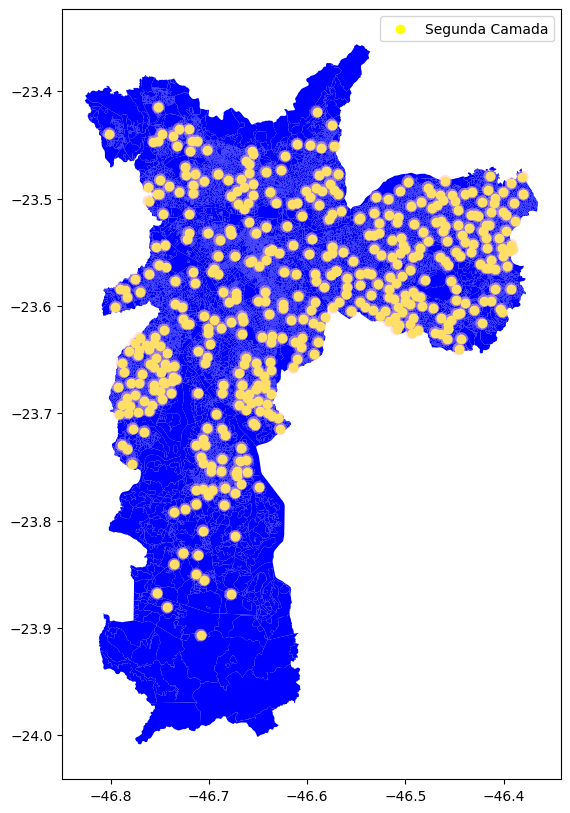

In [59]:
gdf2 = setores_maps.copy()
gdf5 = cnes_to_buffer.copy()
gdf6 = cnes_with_buffer.copy()
over_lay_view_plot = over_lay_view.copy()
fig, ax = plt.subplots(figsize=(10, 10))

gdf2.GEOMETRY.plot(ax=ax, color='blue', alpha=1, label='Primeira Camada')
gdf5.point.plot(ax=ax, color='yellow', alpha=1, label='Segunda Camada')
# gdf6.point.plot(ax=ax, color='pink', alpha=0.5, label='Terceira Camada')
over_lay_view_plot.plot(ax=ax, color='pink', alpha=0.5, label='Terceira Camada')
plt.legend()
plt.show()

### Criar Indicadores com porcentagem das areas

In [60]:
# Verificação Setores Interceptado

populacao_distrital: list = []
porcentagem_coberturas: list = []
for row in over_lay_view.itertuples():
  for row_setores in setores_maps.itertuples():
    if row.point.intersects(row_setores.GEOMETRY):
      populacao_distrital.append(row_setores)
      porcentagem_coberturas.append(overlap_percentage(row.point, row_setores.GEOMETRY))

### % da população distrital a até 1 km de uma UBS
Seguinte fórmula:

$\text{
% da população distrital a até 1 km de uma UBS} = \frac{\text{Pessoas dentro de 1km da UBS}}{\text{Total População}} \times 100$

Indicadores resultante desse codigo:
- % da população distrital a até 1 km de um UBS


In [61]:
df_populacao_distrital_porcent = pd.DataFrame(populacao_distrital)
df_populacao_distrital_porcent['area_coberta_ubs'] = porcentagem_coberturas
df_populacao_distrital_porcent.V0001 = df_populacao_distrital_porcent.V0001.astype(int)

indicador_populacao_distrital_final_porcent = df_populacao_distrital_porcent.groupby(['NM_DIST', 'CD_SETOR', 'V0001'], as_index=False).area_coberta_ubs.sum()
indicador_populacao_distrital_final_porcent['Pessoas dentro de 1km da UBS'] = (indicador_populacao_distrital_final_porcent['area_coberta_ubs'] / 100) * indicador_populacao_distrital_final_porcent.V0001
indicador_populacao_distrital_final_porcent['Pessoas dentro de 1km da UBS'] = indicador_populacao_distrital_final_porcent['Pessoas dentro de 1km da UBS'].round(3)

indicador_populacao_distrital_final_porcent = indicador_populacao_distrital_final_porcent.groupby('NM_DIST')['Pessoas dentro de 1km da UBS'].sum().to_frame('Pessoas dentro de 1km da UBS')

total_populacao_porcent = setores_maps.groupby('NM_DIST').V0001.sum().to_frame('Total População')

indicador_populacao_distrital_final_porcent = pd.concat([indicador_populacao_distrital_final_porcent, total_populacao_porcent], axis=1)
indicador_populacao_distrital_final_porcent['% da população distrital a até 1 km de uma UBS'] = ((indicador_populacao_distrital_final_porcent['Pessoas dentro de 1km da UBS'] / indicador_populacao_distrital_final_porcent['Total População']) * 100).round(3)


## Ler [CNES][cnes] estabelecimentos - Indicador Hospitais

> Tipos de unicadade foi retirado da API: https://apidadosabertos.saude.gov.br/cnes/tipounidades

[cnes]: https://dados.gov.br/dados/conjuntos-dados/cnes-cadastro-nacional-de-estabelecimentos-de-saude



In [62]:
hospitais_cnes_estabelecimentos = pd.read_csv('/content/data/input/cnes_estabelecimentos.csv', dtype=str, sep=';',
                                    encoding='latin-1', usecols=['CO_CNES', 'CO_UNIDADE', 'CO_IBGE', 'TP_UNIDADE', 'NU_LATITUDE', 'NU_LONGITUDE'])

hospitais_filter = (hospitais_cnes_estabelecimentos.CO_IBGE == '355030') & (hospitais_cnes_estabelecimentos.TP_UNIDADE.isin(['62', '5', '7']))
hospitais_cnes_estabelecimentos_sp = hospitais_cnes_estabelecimentos[hospitais_filter]

# Transformar longitue e latitude em Point objeto
hospitais_cnes_estabelecimentos_sp['point'] = hospitais_cnes_estabelecimentos_sp.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)

hospitais_cnes_estabelecimentos_sp_geo_df = gpd.GeoDataFrame(hospitais_cnes_estabelecimentos_sp, geometry='point', crs=4326)

hospitais_cnes_sp_distrito_geo_df = distritos_sp.sjoin(hospitais_cnes_estabelecimentos_sp_geo_df, how='left', predicate='contains')
hospitais_cnes_sp_distrito_geo_df['point'] = hospitais_cnes_sp_distrito_geo_df.apply(lambda row: Point(row.NU_LONGITUDE, row.NU_LATITUDE), axis=1)


### Aplicar buffer

In [63]:
hospitais_cnes_to_buffer = hospitais_cnes_sp_distrito_geo_df.drop('geometry', axis=1)
hospitais_cnes_without_buffer = gpd.GeoDataFrame(hospitais_cnes_to_buffer, geometry="point", crs=4326).to_crs(3003)
hospitais_cnes_with_buffer = hospitais_cnes_without_buffer.copy()
hospitais_cnes_with_buffer.point = hospitais_cnes_with_buffer.point.buffer(5000) # 5 Quilometros
hospitais_cnes_with_buffer = hospitais_cnes_with_buffer.to_crs(4326)

### dissolve dos buffer das Hospitais

In [64]:
hospitais_df_to_union = hospitais_cnes_with_buffer.reset_index()[['point']]
hospitais_uniao_df = hospitais_df_to_union.sjoin(hospitais_df_to_union, how='left', predicate='intersects')
hospitais_over_lay_view = hospitais_uniao_df.dissolve().explode().reset_index(drop=True)

### Visualizar buffer

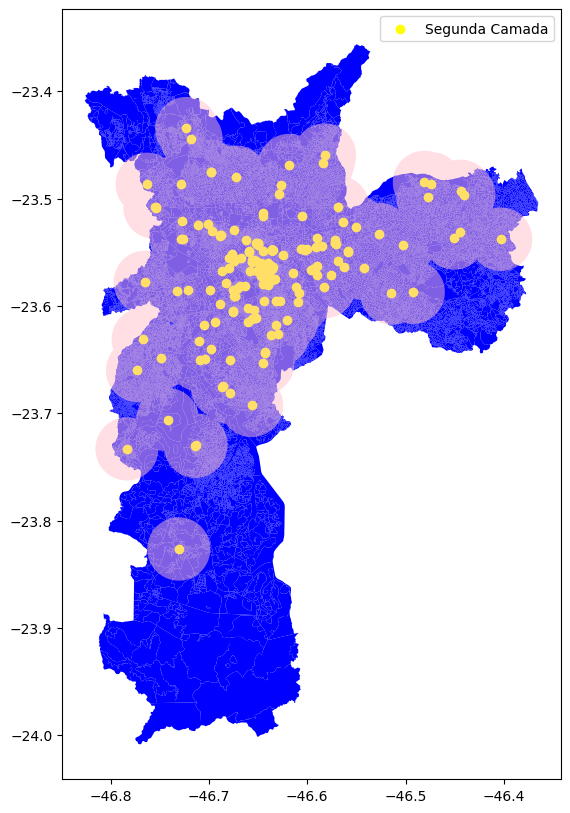

In [65]:
gdf2 = setores_maps.copy()
gdf5 = hospitais_cnes_to_buffer.copy()
gdf6 = hospitais_cnes_with_buffer.copy()
over_lay_view_plot = hospitais_over_lay_view.copy()
fig, ax = plt.subplots(figsize=(10, 10))

gdf2.GEOMETRY.plot(ax=ax, color='blue', alpha=1, label='Primeira Camada')
gdf5.point.plot(ax=ax, color='yellow', alpha=1, label='Segunda Camada')
# gdf6.point.plot(ax=ax, color='pink', alpha=0.5, label='Terceira Camada')
over_lay_view_plot.plot(ax=ax, color='pink', alpha=0.5, label='Terceira Camada')
plt.legend()
plt.show()

### Criar Indicadores com porcentagem das areas

In [66]:
# Verificação Setores Interceptado

hospitais_populacao_distrital: list = []
hospitais_porcentagem_coberturas: list = []
for row in hospitais_over_lay_view.itertuples():
  for row_setores in setores_maps.itertuples():
    if row.point.intersects(row_setores.GEOMETRY):
      hospitais_populacao_distrital.append(row_setores)
      hospitais_porcentagem_coberturas.append(overlap_percentage(row.point, row_setores.GEOMETRY))

### % da população distrital a até 5 km de um Hospital

Seguinte fórmula:

$\text{
% da população distrital a até 5 km de um Hospital} = \frac{\text{Pessoas dentro de 5km da Hospital}}{\text{Total População}} \times 100$

Indicadores resultante desse codigo:
- % da população distrital a até 5 km de um Hospital


In [67]:
hospitais_df_populacao_distrital_porcent = pd.DataFrame(hospitais_populacao_distrital)
hospitais_df_populacao_distrital_porcent['area_coberta_hospital'] = hospitais_porcentagem_coberturas
hospitais_df_populacao_distrital_porcent.V0001 = hospitais_df_populacao_distrital_porcent.V0001.astype(int)

hospitais_indicador_populacao_distrital_final_porcent = hospitais_df_populacao_distrital_porcent.groupby(['NM_DIST', 'CD_SETOR', 'V0001'], as_index=False).area_coberta_hospital.sum()
hospitais_indicador_populacao_distrital_final_porcent['Pessoas dentro de 5km da Hospital'] = (hospitais_indicador_populacao_distrital_final_porcent['area_coberta_hospital'] / 100) * hospitais_indicador_populacao_distrital_final_porcent.V0001
hospitais_indicador_populacao_distrital_final_porcent['Pessoas dentro de 5km da Hospital'] = hospitais_indicador_populacao_distrital_final_porcent['Pessoas dentro de 5km da Hospital'].round(3)

hospitais_indicador_populacao_distrital_final_porcent = hospitais_indicador_populacao_distrital_final_porcent.groupby('NM_DIST')['Pessoas dentro de 5km da Hospital'].sum().to_frame('Pessoas dentro de 5km da Hospital')

hospitais_total_populacao_porcent = setores_maps.groupby('NM_DIST').V0001.sum().to_frame('Total População')

hospitais_indicador_populacao_distrital_final_porcent = pd.concat([hospitais_indicador_populacao_distrital_final_porcent, hospitais_total_populacao_porcent], axis=1)
hospitais_indicador_populacao_distrital_final_porcent['% da população distrital a até 5 km de um Hospital'] = ((hospitais_indicador_populacao_distrital_final_porcent['Pessoas dentro de 5km da Hospital'] / hospitais_indicador_populacao_distrital_final_porcent['Total População']) * 100).round(3)


## Juntar indicadores espaciais

In [68]:
lista_indicadores: list[pd.DataFrame] = [
    indicador_populacao_distrital_final_porcent,
    hospitais_indicador_populacao_distrital_final_porcent,
]

indicadores_espaciais = pd.concat(lista_indicadores, axis=1)
indicadores_espaciais = indicadores_espaciais.rename(columns=dicionario_to_rename)

indicadores_espaciais = indicadores_espaciais.loc[:,~indicadores_espaciais.columns.duplicated()] # Remove Colunas duplicadas.

indicadores_espaciais.index.name = 'Distritos'

# ObservaSampa

- Taxa de distorção idade-série no Ensino Fundamental da Rede Municipal de Ensino (%) -> [Codigo][indicadores_15]

<!-- Taxa de distorção idade-série no Ensino Fundamental da Rede Municipal de Ensino (%) -->

[indicadores_15]: https://colab.research.google.com/drive/14jIloiip7s8xnTffYS55Q0lF8Etwz5W5#scrollTo=9ri0LAVJ01pX

## Taxa de distorção idade-série no Ensino Fundamental da Rede Municipal de Ensino (%)

Indicadores resultante desse codigo:
- Taxa de distorção idade-série no Ensino Fundamental da Rede Municipal de Ensino (%) - ObservaSampa 2023

> Não fico muito claro para mim o que seria esse "dos anos iniciais do Ensino Fundamental" e "dos anos finais do Ensino Fundamental". Peguei apenas `Taxa de distorção idade-série no Ensino Fundamental da Rede Municipal de Ensino (%)` geral de 2023 para simbolizar o indicador pelo menos


In [69]:
url = 'https://observasampa.prefeitura.sp.gov.br/arquivo.php?cd_indicador=84'
distorcao_ensino_fundamental = pd.read_csv(url, sep=';')
selected_distrito = distorcao_ensino_fundamental.nivel_regional == 'Distrito'
distorcao_ensino_fundamental = distorcao_ensino_fundamental[selected_distrito]
distorcao_ensino_fundamental.index = distorcao_ensino_fundamental['região']
distorcao_ensino_fundamental = distorcao_ensino_fundamental['2023'].to_frame('Taxa de distorção idade-série no Ensino Fundamental da Rede Municipal de Ensino (%) - ObservaSampa 2023')

## Taxa de distorção idade-série no Ensino Médio da Rede Municipal de Ensino (%)

Indicadores resultante desse codigo:
- Taxa de distorção idade-série no Ensino Fundamental da Rede Municipal de Ensino (%) - ObservaSampa 2023

In [70]:
url = 'https://observasampa.prefeitura.sp.gov.br/arquivo.php?cd_indicador=87'
distorcao_ensino_medio = pd.read_csv(url, sep=';')
selected_distrito = distorcao_ensino_medio.nivel_regional == 'Distrito'
distorcao_ensino_medio = distorcao_ensino_medio[selected_distrito]
distorcao_ensino_medio.index = distorcao_ensino_medio['região']
distorcao_ensino_medio = distorcao_ensino_medio['2023'].to_frame('Taxa de distorção idade-série no Ensino Medio da Rede Municipal de Ensino (%) - ObservaSampa 2023')

# Junta [Censo 2022][censo-2022], [SIM 2022][ms_sim], [SINASC 2023][sinasc], [INEP Censo Escolar 2023][inep_escola] e [Mapa Desigualdade São Paulo 2024][mapadesigualdadesaopaulo2024]

[censo-2022]: https://www.ibge.gov.br/estatisticas/sociais/trabalho/22827-censo-demografico-2022.html?=&t=downloads
[sinasc]: https://basedosdados.org/dataset/48ccef51-8207-40ee-af5b-134c8ac3fb8c?table=80359f9a-8189-4693-bdf7-ebf7be0d2fff
[ms_sim]: https://basedosdados.org/dataset/5beeec93-cbf3-43f6-9eea-9bee6a0d1683?table=dea823a5-cad7-4014-b77c-4aa33b3b0541
[mapadesigualdadesaopaulo2024]: https://institutocidadessustentaveis.shinyapps.io/mapadesigualdadesaopaulo2024/
[inep_escola]: https://basedosdados.org/dataset/dae21af4-4b6a-42f4-b94a-4c2061ea9de5?table=15e428cb-cce2-41f8-aec5-066d685b5bd5


In [73]:
dfs_indicadores: list[pd.DataFrame] = [
    censo_2022_políticas_sociais,
    indicadores_sinasc,
    indicadores_mapa_desigualdade,
    inep_censo_indicadores,
    indicadores_espaciais,
    pardos_idade_escolar,
    pretos_idade_escolar,
    distorcao_ensino_fundamental]

for df in dfs_indicadores:
  df.index = [slugify(temp_index) for temp_index in df.index]

políticas_sociais = pd.concat(dfs_indicadores, axis=1)
políticas_sociais.to_excel('políticas_sociais.xlsx')

In [74]:
políticas_sociais

,Total de pessoas - Censo 2022,0 a 4 anos - Censo 2022,Proporção de crianças de 0 a 4 anos na população - Censo 2022,total de pessoas de 65 anos ou mais - Censo 2022,% de pessoas de 65 anos ou mais - Censo 2022,Proporção de pessoas acima de 70 anos na população - Censo 2022,Cor ou raça é branca - Censo 2022,Cor ou raça é preta - Censo 2022,Cor ou raça é amarela - Censo 2022,Cor ou raça é parda - Censo 2022,...,% da população distrital a até 1 km de uma UBS,Pessoas dentro de 5km da Hospital,% da população distrital a até 5 km de um Hospital,Quantidade matriculas Parda - INEP 2023,"0 a 29 anos, Cor ou raça é parda - Censo 2022",Taxa de matrículas de crianças pardas - INEP 2023/Censo 2022,Quantidade matriculas preta - INEP 2023,"0 a 29 anos, Cor ou raça é preta - Censo 2022",Taxa de matrículas de crianças pretas - INEP 2023/Censo 2022,Taxa de distorção idade-série no Ensino Fundamental da Rede Municipal de Ensino (%) - ObservaSampa 2023
agua rasa,85788,3457,4.0,15366,17.9,4.2,65762,3407,2309,14223,...,55.754,85788.000,100.000,2045,5217,39.2,249,5217,4.8,"5,5089"
alto de pinheiros,37359,1260,3.4,8661,23.2,6.4,32214,891,1316,2847,...,14.258,37359.000,100.000,453,724,62.6,106,724,14.6,NaN
anhanguera,75360,4572,6.1,5523,7.3,1.7,33317,8132,202,33440,...,17.513,114.992,0.153,4432,15161,29.2,523,15161,3.4,"2,6527"
aricanduva,89574,4413,4.9,13090,14.6,3.6,54352,7720,2135,25229,...,65.247,89574.000,100.000,4330,9952,43.5,522,9952,5.2,"6,0593"
artur alvim,95575,4333,4.5,14137,14.8,3.5,51199,12737,1077,30335,...,75.210,95575.000,100.000,4447,11680,38.1,962,11680,8.2,"2,8086"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vila medeiros,114939,5748,5.0,17203,15.0,3.5,64564,10206,1146,38704,...,85.795,114939.000,100.000,6239,16377,38.1,618,16377,3.8,"7,1066"
vila prudente,105690,4724,4.5,15771,14.9,3.6,73454,5813,2813,23492,...,54.494,87495.379,82.785,2869,9023,31.8,335,9023,3.7,"5,6114"
vila sonia,123748,6314,5.1,16133,13.0,3.3,76491,9669,5268,32108,...,27.404,123394.634,99.714,3338,14187,23.5,415,14187,2.9,"6,1508"
sao domingos,88884,4506,5.1,11991,13.5,3.4,53016,7059,1069,27635,...,45.350,88884.000,100.000,3869,11662,33.2,489,11662,4.2,"5,1045"
